# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [2]:
#import packages
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import cv2
import matplotlib.pyplot as plt
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [4]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
#generator function
def generator(source_path, folder_list, batch_size,img_idx,y,z):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = img_idx#np.arange(0,30)#create a list of image numbers you want to use for a particular video
    x=len(img_idx)
    while True:
        t = np.random.permutation(folder_list)
       # print(len(t),len(source_path))
        num_batches =len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures
                    cropped=image[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(y,z,3))
                    
                    batch_data[folder,idx,:,:,0]=image_resized[:,:,0]/255.0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1]=image_resized[:,:,1]/255.0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2]=image_resized[:,:,2]/255.0 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        remaining_batch_size=len(t)%batch_size
        if remaining_batch_size!=0:
            batch_size=remaining_batch_size
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures
                    cropped=image[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(y,z,3))
                    
                    batch_data[folder,idx,:,:,0]=image_resized[:,:,0]/255.0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1]=image_resized[:,:,1]/255.0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2]=image_resized[:,:,2]/255.0 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU,LSTM, Dropout, Flatten,Conv2D, BatchNormalization, Activation, Conv3D, MaxPooling3D,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.applications import ResNet50V2,ResNet50
from keras.layers import TimeDistributed
from keras.applications import mobilenet


In [7]:
#function for training models
def training(model,train_doc, val_doc, batch_size,img_idx,y,z,num_epochs):
    
    curr_dt_time = datetime.datetime.now()
    train_path = '/home/datasets/Project_data/train'
    val_path = '/home/datasets/Project_data/val'
    num_train_sequences = len(train_doc)
    print('# training sequences =', num_train_sequences)
    num_val_sequences = len(val_doc)
    print('# validation sequences =', num_val_sequences)
    num_epochs = num_epochs# choose the number of epochs
    print ('# epochs =', num_epochs)
        
    #Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.
    train_generator = generator(train_path, train_doc, batch_size,img_idx,y,z)
    val_generator = generator(val_path, val_doc, batch_size,img_idx,y,z)
    
    
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',period=1)

    LR = ReduceLROnPlateau(monitor='val_loss',
        patience=3, 
        verbose=1, 
        factor=0.5, 
        min_lr=0.00001) # write the REducelronplateau code here
    callbacks_list = [checkpoint, LR]
    
    
    #The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
        
    #Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
    hist=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

    return hist

Source path =  /home/datasets/Project_data/train ; batch size = 20
[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


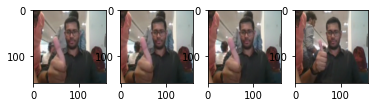

In [8]:
#testing generator function
y=160
z=160
img_idx=np.arange(0,30,1)
#[0,1,2,4,6,8,10,12,14,15,17,19,20,22,24,26,28]
batch_size=20

train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
#np.arange(0,30,1)
g=generator(train_path, train_doc, batch_size,img_idx,y,z)
batch_data, batch_labels=next(g)
print(batch_labels)
fig, axes = plt.subplots(nrows=1, ncols=4)
axes[0].imshow(batch_data[17,0,:,:,:])   
axes[1].imshow(batch_data[17,2,:,:,:])   
axes[2].imshow(batch_data[17,4,:,:,:])   
axes[3].imshow(batch_data[17,6,:,:,:])   

In [9]:
#function for plotting
def plots(history,epochs):

    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# CNN3D
## Model 1

In [9]:
def cnn3d1(x,y,z):
    input_shape = (x,y,z,3)
    model = Sequential()

    model.add(Conv3D(32, kernel_size=(3,3,3),strides=(1,1,1), padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

    model.add(Conv3D(32, kernel_size=(2,2,2),strides=(1,1,1), padding='same', activation='relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

    model.add(Conv3D(64, kernel_size=(2,2,2),strides=(1,1,1), padding='same', activation='relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

    model.add(Conv3D(64, kernel_size=(2,2,2),strides=(1,1,1), padding='same', activation='relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

    
    model.add(Flatten())
    
    model.add(Dense(256))
    model.add(Activation('relu'))
    
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    optimiser = 'adam'#write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model


# Experiment 1
## Resource Exaust 

In [11]:
y=160
z=160
#img_idx=np.arange(0,30,1)
#[0,1,2,4,6,8,10,12,14,15,17,19,20,22,24,26,28]

#x=len(img_idx)

#model=cnn3d1(x,y,z)

#Now that you have written the model, the next step is to `compile` the model.
#When you print the `summary` of the model, you'll see the total number of parameters you have to train.
#print (model.summary())

#num_epochs=15
#batch_size = 40
#experiment with the batch size
#hist=training(model,train_doc, val_doc,batch_size,img_idx,y,z,num_epochs)

Upper Limit determined - we will now check combinations considering the upper limit

ResourceExhaustedError:  OOM when allocating tensor with shape [40,32,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc


# Experiment 2

Reducing image & frame size

- image size=140,140
- img_idx= 17 frames
- epochs=20
- batch size=40

In [ ]:
y=140
z=140
img_idx=[0,1,2,4,6,8,10,12,14,15,17,19,20,22,24,26,28]
#np.arange(0,30,1)
x=len(img_idx)
model=cnn3d1(x,y,z)
#Now that you have written the model, the next step is to `compile` the model.
#When you print the `summary` of the model, you'll see the total number of parameters you have to train.
print (model.summary())

num_epochs=20
batch_size = 40
#experiment with the batch size
hist=training(model,train_doc, val_doc,batch_size,img_idx,y,z,num_epochs)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 17, 140, 140, 32)  2624      
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 8, 70, 70, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 8, 70, 70, 32)     8224      
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 4, 35, 35, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_18 (Conv3D)          (None, 4, 35, 35, 64)     16448     
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 2, 17, 17, 64)   

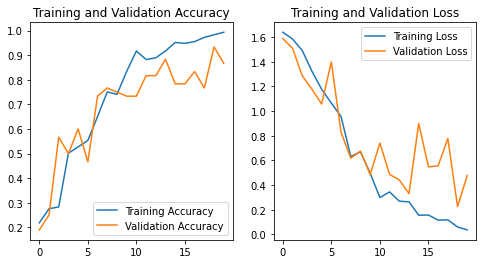

In [ ]:
plots(hist,num_epochs)

 Base model
- Best Training Accuracy - 98 approx
- Best Validation Accuracy - 93 approx

But model needs generalization, trying to generalize but before that lets try with reducing image size

# Experiment 3

- image size=100,100
- img_idx= 17 frames
- epochs=25
- batch size=32

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 17, 100, 100, 32)  2624      
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 8, 50, 50, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 8, 50, 50, 32)     8224      
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 4, 25, 25, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_14 (Conv3D)          (None, 4, 25, 25, 64)     16448     
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 2, 12, 12, 64)   

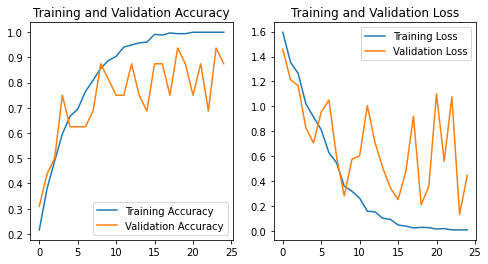

In [16]:

y=100
z=100
img_idx=[0,1,2,4,6,8,10,12,14,15,17,19,20,22,24,26,28]
#np.arange(0,30,1)
x=len(img_idx)
model=cnn3d1(x,y,z)
#Now that you have written the model, the next step is to `compile` the model.
#When you print the `summary` of the model, you'll see the total number of parameters you have to train.
print (model.summary())

num_epochs=25 #20-30
batch_size = 32 # 30-40

hist=training(model,train_doc, val_doc,batch_size,img_idx,y,z,num_epochs)

plots(hist,num_epochs)

- Best Training Accuracy - 100 approx
- Best Validation Accuracy - 94 approx

Model is fluctuating too much after reducing image size, we will maintain an image size between 120-140, trying to generalize 

## Model 2

In [10]:
def cnn3d2(x,y,z):
    input_shape = (x,y,z,3)
    model = Sequential()

    model.add(Conv3D(32, kernel_size=(3,3,3),strides=(1,1,1), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

    model.add(Conv3D(32, kernel_size=(2,2,2),strides=(1,1,1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

    model.add(Conv3D(64, kernel_size=(2,2,2),strides=(1,1,1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

    model.add(Conv3D(64, kernel_size=(2,2,2),strides=(1,1,1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

    
    model.add(Flatten())
    
    model.add(Dense(256))
    model.add(Activation('relu'))
    
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    optimiser = 'adam'#write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model


# Experiment 4

- image size=120,120
- img_idx= 30 frames
- epochs=20
- batch size=32

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 120, 120, 32)  2624      
                                                                 
 batch_normalization_8 (Batc  (None, 30, 120, 120, 32)  128      
 hNormalization)                                                 
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 60, 60, 32)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 60, 60, 32)    8224      
                                                                 
 batch_normalization_9 (Batc  (None, 15, 60, 60, 32)   128       
 hNormalization)                                                 
                                                      

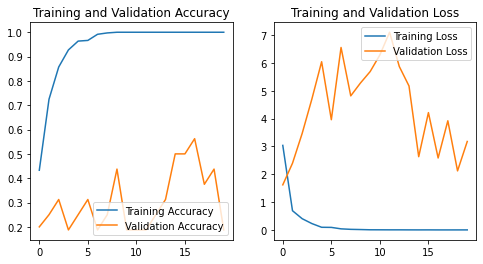

In [13]:

y=120
z=120
img_idx=np.arange(0,30,1)
#[0,1,2,4,6,8,10,12,14,15,17,19,20,22,24,26,28]
#np.arange(0,30,1)
x=len(img_idx)
model=cnn3d2(x,y,z)
#Now that you have written the model, the next step is to `compile` the model.
#When you print the `summary` of the model, you'll see the total number of parameters you have to train.
print (model.summary())

num_epochs=20 #20-30
batch_size = 32 # 30-40

hist=training(model,train_doc, val_doc,batch_size,img_idx,y,z,num_epochs)

plots(hist,num_epochs)


- Best Training Accuracy - 100 approx
- Best Validation Accuracy - 56 approx

Too bad, will try adding dropouts if it can help overcome this

## Model 3

In [33]:
def cnn3d3(x,y,z):
    input_shape = (x,y,z,3)
    model = Sequential()

    model.add(Conv3D(32, kernel_size=(3,3,3),strides=(1,1,1), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

    model.add(Conv3D(32, kernel_size=(3,3,3),strides=(1,1,1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

    model.add(Conv3D(64, kernel_size=(3,3,3),strides=(1,1,1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

    model.add(Conv3D(64, kernel_size=(3,3,3),strides=(1,1,1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

    
    model.add(Flatten())
    
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    optimiser = 'adam'#write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model


# Experiment 5

- image size=120,120
- img_idx= 17 frames
- epochs=15
- batch size=40
- filter size = 3,3,3

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_43 (Conv3D)          (None, 17, 120, 120, 32)  2624      
                                                                 
 batch_normalization_62 (Bat  (None, 17, 120, 120, 32)  128      
 chNormalization)                                                
                                                                 
 max_pooling3d_42 (MaxPoolin  (None, 8, 60, 60, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_44 (Conv3D)          (None, 8, 60, 60, 32)     27680     
                                                                 
 batch_normalization_63 (Bat  (None, 8, 60, 60, 32)    128       
 chNormalization)                                                
                                                     

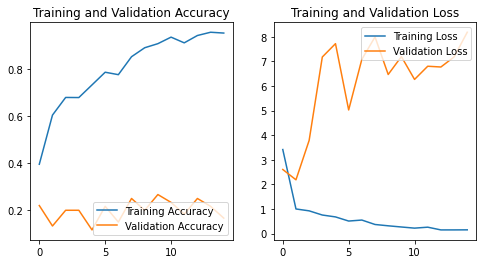

In [34]:

y=120
z=120
img_idx=[0,1,2,4,6,8,10,12,14,15,17,19,20,22,24,26,28]
#np.arange(0,30,1)
x=len(img_idx)
model=cnn3d3(x,y,z)
#Now that you have written the model, the next step is to `compile` the model.
#When you print the `summary` of the model, you'll see the total number of parameters you have to train.
print (model.summary())

num_epochs=15 
batch_size = 40

hist=training(model,train_doc, val_doc,batch_size,img_idx,y,z,num_epochs)

plots(hist,num_epochs)

- Best Training Accuracy - 85 approx
- Best Validation Accuracy - 25 approx

Model is unable to learn, will try CNN+RNN

# CNN RNN

# Mobilenet + GRU
## Model 1


In [ ]:
def cnn2dgru1(x,y,z):
    input_shape = (x,y,z,3)

    Mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)
    
    model = Sequential()

    model.add(TimeDistributed(Mobilenet, input_shape=input_shape))

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(GRU(64))
    #model.add(Dropout(0.25))
    model.add(Dense(16))
    model.add(Dropout(0.20))
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    optimiser = 'adam'#write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model


# Experiment 6
**Tried using Resnet but total trainable parameters where huge and will not justify using for webcams so using mobilenet for lightweight models (for training all parameters)**

Mobilenet (training all weights) + GRU

- image size=130,130
- img_idx= 17 frames (30 frames showed similar results)
- epochs=25
- batch size=40

In [ ]:

y=130
z=130
img_idx=[0,1,2,4,6,8,10,12,14,15,17,19,20,22,24,26,28]
#np.arange(0,30,1)
x=len(img_idx)
model=cnn2dgru1(x,y,z)
#Now that you have written the model, the next step is to `compile` the model.
#When you print the `summary` of the model, you'll see the total number of parameters you have to train.
print (model.summary())

num_epochs=25
batch_size = 40
#experiment with the batch size
hist=training(model,train_doc, val_doc,batch_size,img_idx,y,z,num_epochs)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 17, 4, 4, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 17, 4, 4, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 17, 2, 2, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 17, 4096)         0         
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, 64)               

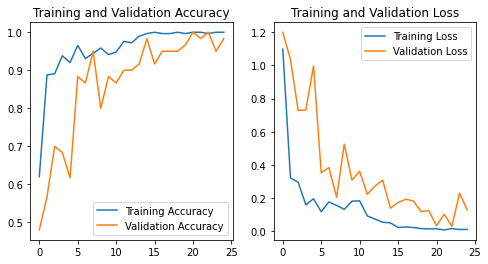

In [ ]:
plots(hist,num_epochs)

Best model till now with accuracy but trainable parameters is high as we trained all parameters will try freezing them next

- Best Training Accuracy - 99 approx
- Best Validation Accuracy - 99 approx


# Mobilenet + GRU
## Model 2

In [ ]:
def cnn2dgru2(x,y,z):
    input_shape = (x,y,z,3)

    Mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)
    Mobilenet.trainable=False
    model = Sequential()

    model.add(TimeDistributed(Mobilenet, input_shape=input_shape))

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(GRU(64))
    #model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.30))
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    optimiser = 'adam'#write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model


# Experiment 7

Mobilenet (freeze weights) + GRU

- image size=130,130
- img_idx= 17 frames (30 frames showed similar results)
- epochs=25
- batch size=40

In [ ]:

y=130
z=130
img_idx=[0,1,2,4,6,8,10,12,14,15,17,19,20,22,24,26,28]
#np.arange(0,30,1)
x=len(img_idx)
model=cnn2dgru2(x,y,z)
#Now that you have written the model, the next step is to `compile` the model.
#When you print the `summary` of the model, you'll see the total number of parameters you have to train.
print (model.summary())

num_epochs=25
batch_size = 40
#experiment with the batch size
hist=training(model,train_doc, val_doc,batch_size,img_idx,y,z,num_epochs)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeDi  (None, 17, 4, 4, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 17, 4, 4, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 17, 2, 2, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 17, 4096)         0         
 stributed)                                                      
                                                                 
 gru_4 (GRU)                 (None, 64)               

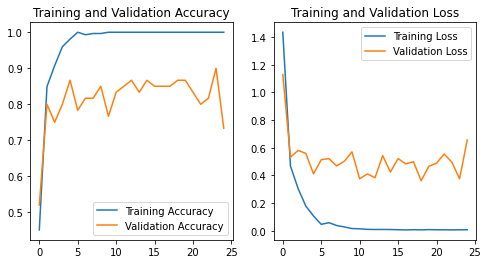

In [ ]:
plots(hist,num_epochs)

We see there is huge overfitting when we freeze the trainable weights of Mobilenet, will try increasing dropout

- Best Training Accuracy - 100 approx
- Best Validation Accuracy - 87 approx


# Mobilenet + GRU
## Model 3

In [ ]:
def cnn2dgru3(x,y,z):
    input_shape = (x,y,z,3)

    Mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)
    Mobilenet.trainable=False
    model = Sequential()

    model.add(TimeDistributed(Mobilenet, input_shape=input_shape))

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(GRU(64))
    model.add(Dropout(0.30))
    model.add(Dense(64))
    model.add(Dropout(0.30))
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    optimiser = 'adam'#write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model


# Experiment 8

Mobilenet (freeze weights) + GRU

- image size=130,130
- img_idx= 17 frames (30 frames showed similar results)
- epochs=25
- batch size=40

In [ ]:
y=130
z=130
img_idx=[0,1,2,4,6,8,10,12,14,15,17,19,20,22,24,26,28]
#np.arange(0,30,1)
x=len(img_idx)
model=cnn2dgru3(x,y,z)
#Now that you have written the model, the next step is to `compile` the model.
#When you print the `summary` of the model, you'll see the total number of parameters you have to train.
print (model.summary())

num_epochs=25
batch_size = 40
#experiment with the batch size
hist=training(model,train_doc, val_doc,batch_size,img_idx,y,z,num_epochs)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_22 (TimeDi  (None, 17, 4, 4, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 17, 4, 4, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_24 (TimeDi  (None, 17, 2, 2, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 17, 4096)         0         
 stributed)                                                      
                                                                 
 gru_5 (GRU)                 (None, 64)               

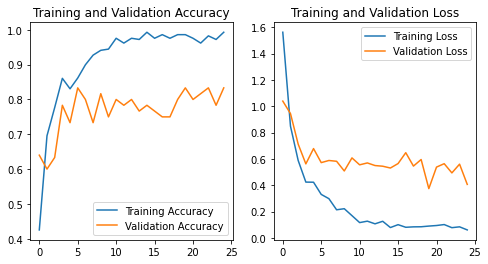

In [ ]:
plots(hist,num_epochs)

There is still overfitting persisting will try using Resnet as it can help with better feature extraction and adding droputs and GRU layers for better learning

- Best Training Accuracy - 99 approx
- Best Validation Accuracy - 86 approx


# Resnet + GRU
## Model 4 (Final)


In [ ]:
def cnn2dgru4(x,y,z):
    input_shape = (x,y,z,3)

    #Mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)
    resnet=ResNet50V2(weights='imagenet', include_top=False,input_shape=(y,z,3))
    
    resnet.trainable=False
    model = Sequential()

    model.add(TimeDistributed(resnet, input_shape=input_shape))

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(GRU(64,return_sequences=True))
    model.add(GRU(32,return_sequences=True))
    model.add(GRU(16))
    model.add(Dropout(0.50))
    model.add(Dense(16))
    model.add(Dropout(0.50))
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    optimiser = 'adam'#write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model


# Experiment 9 (Final)

Resnet (freeze weights) + GRU

- image size=130,130 (120 showed fluctuations)
- img_idx= 17 frames (30 frames showed similar results)
- epochs=20
- batch size=40

In [ ]:
y=130
z=130
img_idx=[0,1,2,4,6,8,10,12,14,15,17,19,20,22,24,26,28]
#np.arange(0,30,1)
x=len(img_idx)
model=cnn2dgru4(x,y,z)
#Now that you have written the model, the next step is to `compile` the model.
#When you print the `summary` of the model, you'll see the total number of parameters you have to train.
print (model.summary())

num_epochs=20
batch_size = 40
#experiment with the batch size
hist=training(model,train_doc, val_doc,batch_size,img_idx,y,z,num_epochs)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_58 (TimeDi  (None, 17, 5, 5, 2048)   23564800  
 stributed)                                                      
                                                                 
 time_distributed_59 (TimeDi  (None, 17, 5, 5, 2048)   8192      
 stributed)                                                      
                                                                 
 time_distributed_60 (TimeDi  (None, 17, 2, 2, 2048)   0         
 stributed)                                                      
                                                                 
 time_distributed_61 (TimeDi  (None, 17, 8192)         0         
 stributed)                                                      
                                                                 
 gru_22 (GRU)                (None, 17, 64)          

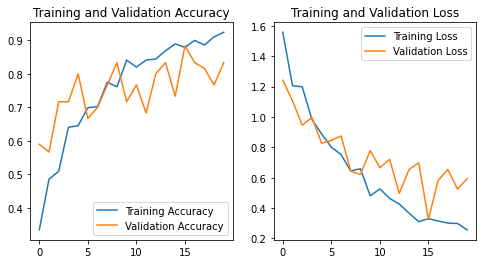

In [ ]:
plots(hist,num_epochs)

- Best Training Accuracy - 88 approx
- Best Validation Accuracy - 88 approx

There is no such overfitting issue and accuracy and overall parameters number is also within range

In [ ]:
#rm -rf ~/.local/share/Trash/*

# CNN2D + GRU
## Model 1

In [24]:
def cnn2dgru5(x,y,z):
    input_shape = (x,y,z,3)
    
    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                              input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))


    model.add(GRU(128))
    model.add(Dropout(0.25))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(5, activation='softmax'))
    optimiser = 'adam'#write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model


# Experiment 10

CNN2D + GRU

- image size=120,120
- img_idx= 17 frames
- epochs=15
- batch size=40

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_48 (TimeDi  (None, 17, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 17, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_50 (TimeDi  (None, 17, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_51 (TimeDi  (None, 17, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_52 (TimeDi  (None, 17, 60, 60, 32) 

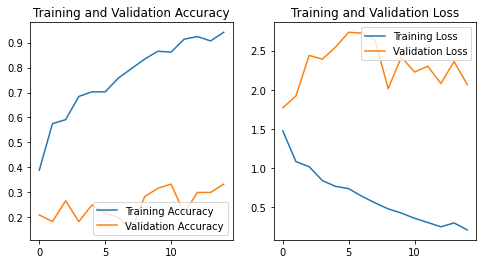

In [28]:

y=120
z=120
img_idx=[0,1,2,4,6,8,10,12,14,15,17,19,20,22,24,26,28]
#np.arange(0,30,1)
x=len(img_idx)
model=cnn2dgru5(x,y,z)
#Now that you have written the model, the next step is to `compile` the model.
#When you print the `summary` of the model, you'll see the total number of parameters you have to train.
print (model.summary())

num_epochs=15
batch_size = 40
#experiment with the batch size
hist=training(model,train_doc, val_doc,batch_size,img_idx,y,z,num_epochs)
plots(hist,num_epochs)

- Best Training Accuracy - 94 approx
- Best Validation Accuracy - 33 approx

we will use transfer learning as suggested

In [14]:
def cnn2dgru6(x,y,z):
    input_shape = (x,y,z,3)

    #Mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)
    resnet=ResNet50V2(weights='imagenet', include_top=False,input_shape=(y,z,3))
    
    resnet.trainable=False
    model = Sequential()

    model.add(TimeDistributed(resnet, input_shape=input_shape))

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(GRU(64,return_sequences=True))
    model.add(GRU(32,return_sequences=True))
    model.add(GRU(16))
    model.add(Dropout(0.50))
    model.add(Dense(64))
    model.add(Dropout(0.50))
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    optimiser = 'adam'#write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model


In [81]:
y=130
z=130
img_idx=[0,1,2,4,6,8,10,12,14,15,17,19,20,22,24,26,28]
#np.arange(0,30,1)
x=len(img_idx)
model=cnn2dgru6(x,y,z)
#Now that you have written the model, the next step is to `compile` the model.
#When you print the `summary` of the model, you'll see the total number of parameters you have to train.
print (model.summary())

num_epochs=20
batch_size = 40
#experiment with the batch size
hist=training(model,train_doc, val_doc,batch_size,img_idx,y,z,num_epochs)

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_112 (TimeD  (None, 17, 5, 5, 2048)   23564800  
 istributed)                                                     
                                                                 
 time_distributed_113 (TimeD  (None, 17, 5, 5, 2048)   8192      
 istributed)                                                     
                                                                 
 time_distributed_114 (TimeD  (None, 17, 2, 2, 2048)   0         
 istributed)                                                     
                                                                 
 time_distributed_115 (TimeD  (None, 17, 8192)         0         
 istributed)                                                     
                                                                 
 gru_84 (GRU)                (None, 17, 64)          

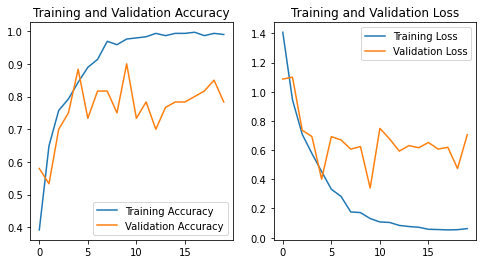

In [82]:
plots(hist,num_epochs)